In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# ODE Layer

In [22]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.weight = nn.Parameter(torch.Tensor(self.in_dim, self.hid_dim, self.out_dim))
        self.reset_parameters()
    
    def forward(self, x):
        xBx = x.matmul(self.weight).matmul(x.t()).permute(2,1,0)
        out = torch.diagonal(xBx).t()
        return out
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

# ODE Model

In [23]:
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, bias=False):
        super(NNODEModel, self).__init__()
        #Dimension
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.bias = bias
        
        #Layer 
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim, self.bias)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
        #weight init
        self.lin_ode.weight.data.uniform_(-0.1,0.1)
        if self.bias:
            self.lin_ode.bias.data.uniform_(-0.1,0.1)
        self.nl_ode.weight.data.uniform_(-0.01,0.01)
            
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out

# Utils

In [64]:
def train_model(model, train_x, train_y, loss_fn, optimizer, batch_size):
    train_loss = 0
    for b in range(0, train_x.size(0), batch_size):
        model.zero_grad()
        pred = model(train_x.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_y.narrow(0, b, batch_size))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss



def generate_pendulum(k, sol, dt=1, T=100, dim=2):
    A = np.asarray([[0,1],[-k,0]])
    I = np.eye(dim)
    AA = (I + dt*A)
    for i in range(T):
        sol.append(np.dot(np.asarray(sol[-1]),AA))
    
    X = np.asarray(sol)[:-1]
    Y = np.asarray(sol)[1:]
    train_x = torch.FloatTensor(X)
    train_y = torch.FloatTensor(Y)
    return train_x, train_y, torch.Tensor(AA)


def generate_lorenz(sigma, rho, beta, sol, dt=0.01, T=10000, dim=3):
    A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
    Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
    Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
    Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt
    
    B = np.array([Q0, Q1, Q2])

    I = np.eye(dim)
    AA = (I+dt*A)
    
    for i in range(T):
        x = np.asarray(sol[-1])
        Ax = AA.dot(x)
    
        phix = x.T.dot(B).dot(x)
    
        f = Ax + phix
        sol.append(f)
    
    X = np.asarray(sol)[:-1]
    Y = np.asarray(sol)[1:]
    train_x = torch.FloatTensor(X)
    train_y = torch.FloatTensor(Y)
    
    return train_x, train_y, torch.Tensor(A), torch.Tensor(B)

def training_session(model, train_x, train_y, lr=1e-2, n_print=10, n_epoch=100, batch_size=1, print_feat=False):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=lr)
    print('Initial weigths of the matrix:')
    print(list(model.parameters()))

    train_loss = []

    for epoch in range(n_epoch):
        loss = train_model(model, train_x_noise, train_y_noise, loss_fn, optimizer, batch_size)
        train_loss.append(loss)
        if print_feat:
            if epoch%n_print == 0:
                print('\n\n\nEpoch:', epoch+1, 'train_loss:', loss)
                print('weight:')
                print(list(model.parameters()))
    
    print('Final weigths of the matrix:')
    print(list(model.parameters()))
    weights = model.state_dict()
    lin_weight = weights['lin_ode.weight']
    nl_weight = weights['nl_ode.weight']
    plt.plot(train_loss)
    plt.show()
    return train_loss, lin_weight, nl_weight

def prediction(lin_weight, nl_weight, sol, T):
    for i in range(100):
        x = np.asarray(sol[-1])
        Ax = lin_weight.dot(x)
    
        phix = x.T.dot(nl_weight).dot(x)
    
        f = Ax + phix
        sol.append(f)
    return np.array(sol)

# Pendulum

## Data exploration

In [25]:
k = 0.01
sol = [[0.99,1]]
train_x, train_y, H = generate_pendulum(k, sol)
print('Parameter:')
print(H)
print('train_x size:', train_x.size())
print('train_y size:', train_y.size())

Parameter:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
train_x size: torch.Size([100, 2])
train_y size: torch.Size([100, 2])


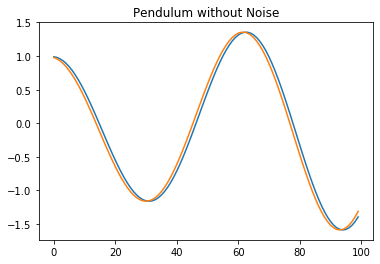

In [9]:
plt.plot(train_x[:,0].numpy());
plt.plot(train_y[:,0].numpy())
plt.title('Pendulum without Noise')
plt.show()

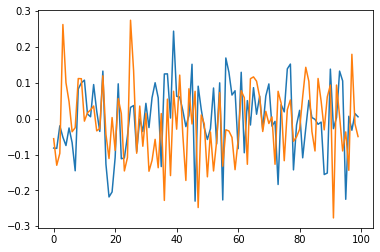

In [26]:
# Add noise to data
seed = 10
torch.manual_seed(10)
std = 0.1 #10% of the bound pendulum
noise = torch.randn(100,2)*std
plt.plot(noise.numpy())
plt.show()

In [27]:
train_x_noise = train_x + noise
train_y_noise = train_y + noise

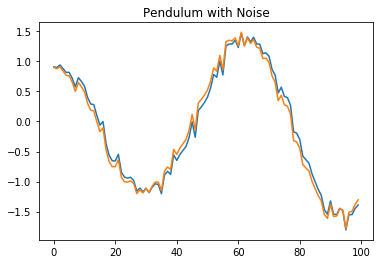

In [28]:
plt.plot(train_x_noise[:,0].numpy());
plt.plot(train_y_noise[:,0].numpy())
plt.title('Pendulum with Noise')
plt.show()

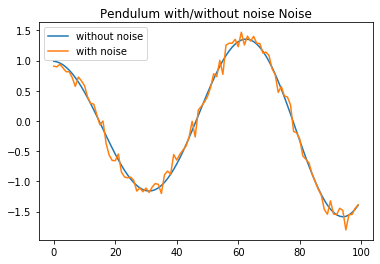

In [29]:
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

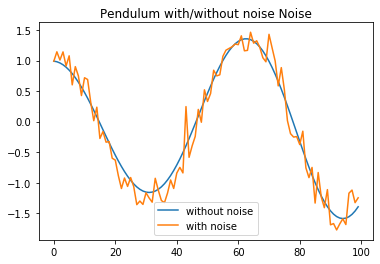

In [45]:
std = 0.2
noise2 = torch.randn(100,2)*std
train_x_noise2 = train_x + noise2
train_y_noise2 = train_y + noise2
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise2[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

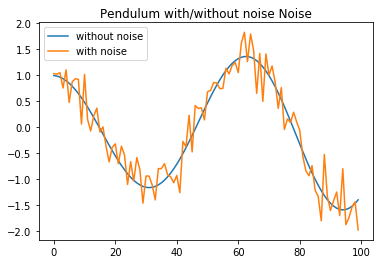

In [46]:
std = 0.3
noise3 = torch.randn(100,2)*std
train_x_noise3 = train_x + noise3
train_y_noise3 = train_y + noise3
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise3[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

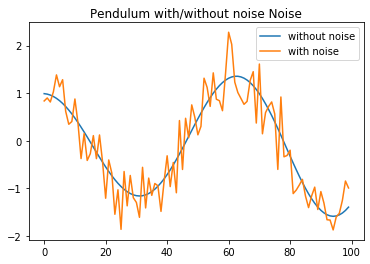

In [47]:
std = 0.4
noise4 = torch.randn(100,2)*std
train_x_noise4 = train_x + noise4
train_y_noise4 = train_y + noise4
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise4[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

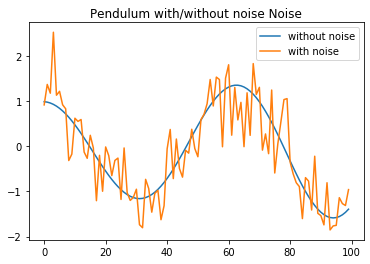

In [48]:
std = 0.5
noise5 = torch.randn(100,2)*std
train_x_noise5 = train_x + noise5
train_y_noise5 = train_y + noise5
plt.plot(train_x[:,0].numpy(), label='without noise');
plt.plot(train_x_noise5[:,0].numpy(), label='with noise')
plt.title('Pendulum with/without noise Noise')
plt.legend()
plt.show()

## Training the model

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.0845,  0.0835],
        [-0.0038, -0.0808]], requires_grad=True), Parameter containing:
tensor([[[0.0033, 0.0052],
         [0.0060, 0.0061]],

        [[0.0054, 0.0022],
         [0.0007, 0.0050]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9475,  0.5142],
        [-0.0115,  0.9262]], requires_grad=True), Parameter containing:
tensor([[[-2.4936e-02, -8.5775e-05],
         [ 6.7674e-04, -2.7609e-05]],

        [[-5.5329e-02,  3.1877e-03],
         [ 1.7054e-03,  2.5755e-03]]], requires_grad=True)]


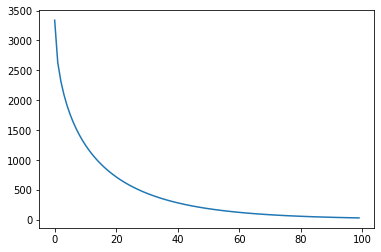

In [31]:
#without noise
print('Initial matrix H:')
print(H)


model = NNODEModel(2,2,2)

train_loss = training_session(model, train_x, train_y)
weights = model.state_dict()
lin_weight = weights['lin_ode.weight']

In [60]:
param = model.state_dict()

In [61]:
param['lin_ode.weight']

tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]])

In [62]:
param['nl_ode.weight']

tensor([[[-4.5370e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5491e-07]],

        [[-5.0088e-03, -2.5280e-04],
         [-1.7351e-03, -2.3269e-04]]])

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.9475,  0.5142],
        [-0.0115,  0.9262]], requires_grad=True), Parameter containing:
tensor([[[-2.4936e-02, -8.5775e-05],
         [ 6.7674e-04, -2.7609e-05]],

        [[-5.5329e-02,  3.1877e-03],
         [ 1.7054e-03,  2.5755e-03]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 1.0000,  0.9793],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-6.0657e-05, -3.7365e-04],
         [ 3.8887e-04,  5.7403e-07]],

        [[-5.5336e-03, -2.9314e-04],
         [-1.7754e-03, -2.3213e-04]]], requires_grad=True)]


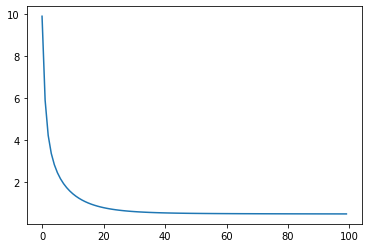

In [32]:
#with noise
print('Initial matrix H:')
print(H)


train_loss_noise = training_session(model, train_x_noise, train_y_noise)

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 1.0000,  0.9793],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-6.0657e-05, -3.7365e-04],
         [ 3.8887e-04,  5.7403e-07]],

        [[-5.5336e-03, -2.9314e-04],
         [-1.7754e-03, -2.3213e-04]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5216e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5767e-07]],

        [[-5.0089e-03, -2.5280e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]


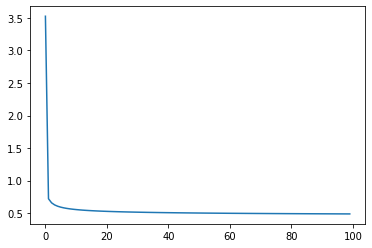

In [49]:
#noise with sigma=0.2
print('Initial matrix H:')
print(H)

train_loss_noise2 = training_session(model, train_x_noise2, train_y_noise2)

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5216e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5767e-07]],

        [[-5.0089e-03, -2.5280e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5370e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5472e-07]],

        [[-5.0088e-03, -2.5281e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]


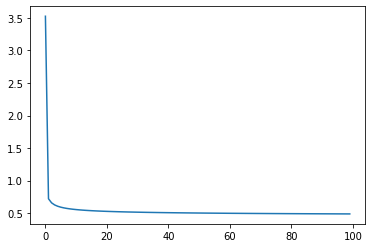

In [50]:
print('Initial matrix H:')
print(H)

train_loss_noise3 = training_session(model, train_x_noise3, train_y_noise3)

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5370e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5472e-07]],

        [[-5.0088e-03, -2.5281e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5331e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5700e-07]],

        [[-5.0088e-03, -2.5280e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]


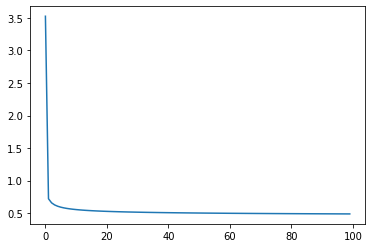

In [51]:
print('Initial matrix H:')
print(H)

train_loss_noise4 = training_session(model, train_x_noise4, train_y_noise4)

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5331e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5700e-07]],

        [[-5.0088e-03, -2.5280e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 1.0001,  0.9802],
        [-0.0100,  1.0017]], requires_grad=True), Parameter containing:
tensor([[[-4.5370e-05, -3.7478e-04],
         [ 3.8774e-04,  7.5491e-07]],

        [[-5.0088e-03, -2.5280e-04],
         [-1.7351e-03, -2.3269e-04]]], requires_grad=True)]


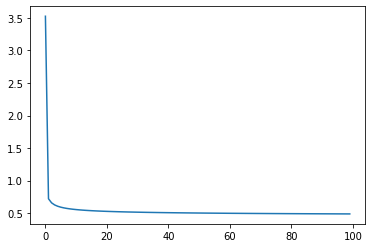

In [52]:
print('Initial matrix H:')
print(H)

train_loss_noise5 = training_session(model, train_x_noise5, train_y_noise5)

In [53]:
print('train_loss min:', train_loss[99])
print('train_loss_noise min:', train_loss_noise[99])
print('train_loss_noise2 min:', train_loss_noise2[99])
print('train_loss_noise3 min:', train_loss_noise3[99])
print('train_loss_noise4 min:', train_loss_noise4[99])
print('train_loss_noise5 min:', train_loss_noise5[99])

train_loss min: 30.724945224748808
train_loss_noise min: 0.48759748779207257
train_loss_noise2 min: 0.4880063081419621
train_loss_noise3 min: 0.48800420907889475
train_loss_noise4 min: 0.4880046197863521
train_loss_noise5 min: 0.4880042292217581


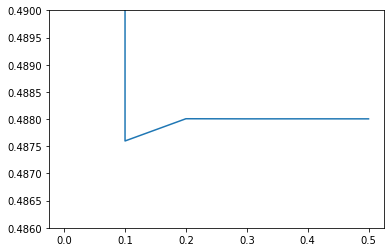

In [55]:
noise_loss = np.array([train_loss[99], train_loss_noise[99],train_loss_noise2[99], train_loss_noise3[99], train_loss_noise4[99], train_loss_noise5[99]])
noise = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.plot(noise,noise_loss)
plt.ylim(0.486,0.49)
plt.show()

In [34]:
param_model_noise = model.state_dict()
param_model_noise

OrderedDict([('lin_ode.weight', tensor([[ 1.0000,  0.9793],
                      [-0.0100,  1.0017]])),
             ('nl_ode.weight', tensor([[[-6.0657e-05, -3.7365e-04],
                       [ 3.8887e-04,  5.7403e-07]],
              
                      [[-5.5336e-03, -2.9314e-04],
                       [-1.7754e-03, -2.3213e-04]]]))])

In [35]:
AA = param_model_noise['lin_ode.weight']
BB = param_model_noise['nl_ode.weight']

In [36]:
AA = AA.numpy()
AA#noise1

array([[ 1.0000494 ,  0.9793138 ],
       [-0.00996045,  1.0016546 ]], dtype=float32)

In [37]:
BB = BB.numpy()
BB#noise1

array([[[-6.0657490e-05, -3.7364900e-04],
        [ 3.8887147e-04,  5.7403088e-07]],

       [[-5.5335956e-03, -2.9313681e-04],
        [-1.7754098e-03, -2.3212789e-04]]], dtype=float32)

In [38]:
sol = [[0.99,1]]
for i in range(100):
    x = np.asarray(sol[-1])
    Ax = AA.dot(x)
    
    phix = x.T.dot(BB).dot(x)
    
    f = Ax + phix
    sol.append(f)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]

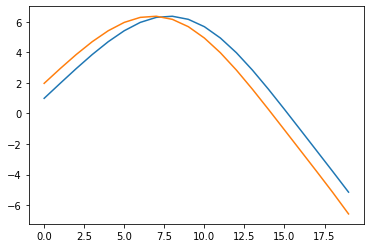

In [44]:
plt.plot(X[0:20,0]);
plt.plot(Y[0:20,0])
plt.show()

# The test

28.11.2019:

data = pendulum

real = [[1, 1],[-0.01, 1]]

without noise:

min loss = 28.26,

weight = [[0.938, 0.4303],[-0.0119, 1.0016]]

with noise:

variance = 0.1

min loss = 0.4874

weight = [[1, 0.9783],[-0.01, 0.9200]]

In [49]:
parameters

OrderedDict([('lin_ode.weight', tensor([[ 0.9238,  0.4303],
                      [-0.0119,  0.9299]])),
             ('nl_ode.weight', tensor([[[-3.7551e-02,  1.4964e-05],
                       [ 9.5858e-04, -2.3710e-05]],
              
                      [[-9.5003e-02, -1.2854e-03],
                       [ 8.5948e-03,  2.5669e-03]]]))])

# Real Data

In [18]:
data_path = '../data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

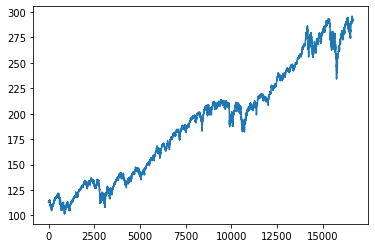

In [19]:
plt.plot(data.values)
plt.show()

In [20]:
spy=data.values.reshape((1,-1))[0]